<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/Outbreak_Detections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
install.packages(c("surveillance", "forecast"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [6]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(readr)

library(surveillance)  # For Farrington & EARS
library(forecast)      # For ARIMA


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: sp

Loading required package: xtable

This is surveillance 1.24.1; see ‘package?surveillance’ or
https://surveillance.R-Forge.R-project.org/ for an overview.

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:surveillance’:

    ses




# Make R in Colab works with Drive

In [7]:
if (file.exists("/usr/local/lib/python3.6/dist-packages/google/colab/_ipython.py")) {
  install.packages("R.utils")
  library(R.utils)
  library(httr)
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check)
  options(rlang_interactive=TRUE)
}

In [8]:
packages <- c("googledrive", "googlesheets4")
if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
  install.packages(setdiff(packages, rownames(installed.packages())))
}

In [9]:
library(googledrive)
library(googlesheets4)


Attaching package: ‘googlesheets4’


The following objects are masked from ‘package:googledrive’:

    request_generate, request_make




In [10]:
# Save cache in a file so that i don't have to authenticate repeatedly
drive_auth(cache = "/content/drive/My Drive/.secrets", use_oob = TRUE)

The googledrive package is requesting access to your Google account.
Enter '1' to start a new auth process or select a pre-authorized account.
1: Send me to the browser for a new auth process.
2: nadillia.sahputra@isi.it


Selection: 2


# Read Data

In [11]:
drive_download(file = "satscan_data/simulation_data(2000 days).csv",
               path = "simulation_data_2000days.csv",
               overwrite = TRUE)

data <- read_csv("simulation_data_2000days.csv")
data <- data %>% rename(True_Outbreak = "True Outbreak")
data <- data %>% rename(Reported_Cases = "Reported Cases")
data$Population <- data$Susceptible + data$Infected + data$Recovered
data$Region <- data$Region + 1 #Convert from (0 - 2) to (1 - 3) due to R indexing
head(data)

File downloaded:

• simulation_data(2000 days).csv <id: 1oy9Qy_AalMixQtcXx1M1BXT5udp1sH9c>

Saved locally as:

• simulation_data_2000days.csv

Rows: 6000 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (7): Day, Region, Susceptible, Infected, Recovered, Reported Cases, True...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Day,Region,Susceptible,Infected,Recovered,Reported_Cases,True_Outbreak,Population
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,9985,10,5,0,0,10000
1,1,9550,13,4,1,0,9567
2,1,9614,15,5,3,0,9634
3,1,11022,16,8,1,0,11046
4,1,10239,17,10,0,0,10266
5,1,10436,13,14,2,0,10463


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


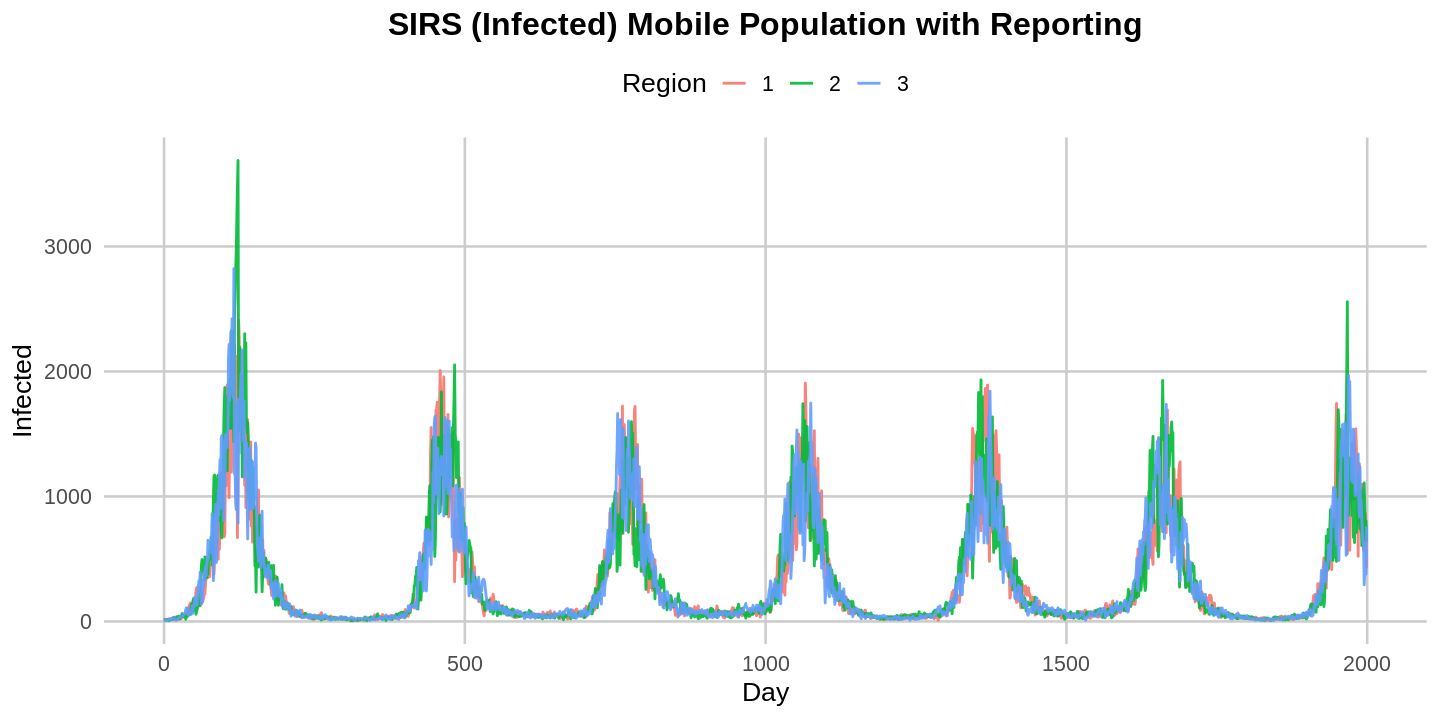

In [12]:
# PLot to determine the inital period that I want to discard
options(repr.plot.width = 12, repr.plot.height = 6)
ggplot(data, aes(x = Day, y = Infected, color = factor(Region))) +
  geom_line(size = 0.8, alpha = 0.9) +
  labs(
    title = "SIRS (Infected) Mobile Population with Reporting",
    x     = "Day",
    y     = "Infected",
    color = "Region"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    panel.grid.major  = element_line(color = "grey80"),
    panel.grid.minor  = element_blank(),
    plot.title        = element_text(face = "bold", hjust = 0.5),
    legend.position   = "top"
  )


In [13]:
burn_in <- 250 # Discard the initial 250 days
data_processed <- data %>% filter(Day > burn_in) # "data_processed" is the name of dataset that i will use to process from now-n

# Summarise when the outbreak starts and end (mostly for plotting purposes)
outbreak_periods <- data_processed %>%
  arrange(Day) %>%
  mutate(
    start_flag = (True_Outbreak == 1) & (lag(True_Outbreak, default = 0) == 0), # Start day must be when the day now has label 1 and yesterday 0
    end_flag   = (True_Outbreak == 0) & (lag(True_Outbreak, default = 1) == 1)  # End day must be when the day now has label 0 and yesterday 1
  ) %>%
  mutate(group = cumsum(start_flag)) %>%
  filter(True_Outbreak == 1) %>%
  group_by(group) %>%
  summarise(
    start = min(Day),
    end   = max(Day)
  )

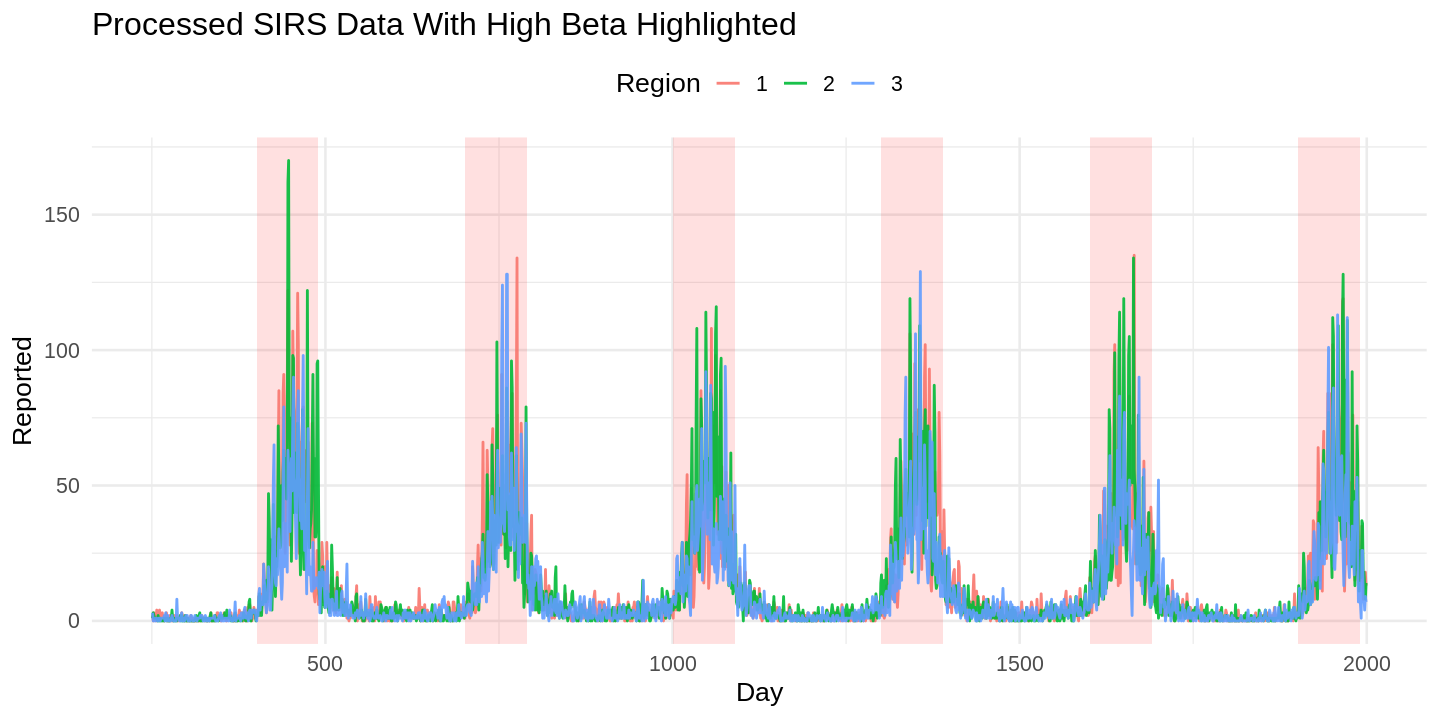

In [14]:
ggplot(data_processed, aes(x = Day, y = Reported_Cases, color = factor(Region))) +
  geom_rect(
    data = outbreak_periods,
    aes(xmin = start, xmax = end, ymin = -Inf, ymax = Inf),
    fill = "red", alpha = 0.12, inherit.aes = FALSE # The period when beta is high (outbreak) is highlighted with red
  ) +
  geom_line(size = 0.8, alpha = 0.9) +
  labs(
    title = "Processed SIRS Data With High Beta Highlighted",
    x = "Day",
    y = "Reported",
    color = "Region"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    legend.position = "top"
  )


# **Detection**

In [15]:
detect_farrington <- function(df, b = 1, w = 2, noPeriods = 1, pastWeeksNotIncluded = 0, trend = FALSE) {

  # Aggregate to weekly because farrington flexible is available only weekly
  df_week <- df %>%
    mutate(Week = floor((Day - min(Day))/7) + 1) %>%
    group_by(Week) %>%
    summarise(
      Reported_Cases = sum(Reported_Cases)
    )

  # Create the sts object (because it is required the input to be sts object) and run farrington flexible
  sts_week <- sts(observed = df_week$Reported_Cases, freq = 1)
  farr_week <- farringtonFlexible(
    sts_week,
    control = list(
      b = b, w = w, noPeriods = noPeriods,
      pastWeeksNotIncluded = pastWeeksNotIncluded,
      trend = trend,
      alpha = 0.05
    )
  )
  # Convert alarms to 0(no outbreak)/1(outbreak)
  farr_week_signal <- as.numeric(alarms(farr_week) > 0)
  # Convert weekly to daily
  farr_signal_daily <- rep(farr_week_signal, each = 7)

  return(farr_signal_daily)
}

In [16]:
detect_ears <- function(df, method = "C3", baseline = 63) {

  # Convert to sts object
  sts_cases <- sts(observed = df$Reported_Cases, freq = 1)
  # EARS with the method can be C1/C2/C3 and baseline is the temporal window
  ears <- earsC(sts_cases, control = list(method = method, baseline = baseline))
  # Convert alarms to 0(no outbreak)/1(outbreak)
  ears_signal <- as.numeric(alarms(ears) > 0)
  return(ears_signal)
}


In [17]:
# detect_arima <- function(df, burn_in = 250, interval = 0.95) {

#   # Use auto ARIMA to pick the estimated coefficients
#   arima_fit <- auto.arima(df$Reported_Cases)

#   # Do the forecast, based on the burn-in days
#   pred <- forecast(arima_fit, h = nrow(df) - burn_in)

#   # Detection threshold : First burn-in days are for training therefore set to 0,
#   # the rest take the upper interval of the prediction as a threshold
#   pred_upper <- c(rep(NA, burn_in), pred$upper[,2])

#   # If the cases is bigger than the upper bounds of the predicted interval then "Raises Alarm"
#   arima_signal <- as.numeric(df$Reported_Cases > pred_upper)
#   arima_signal[is.na(arima_signal)] <- 0  # set NA to 0 (no alarm in burn-in)

#   return(arima_signal)
# }


In [23]:
# Revision for ARIMA
detect_arima <- function(df, burn_in = 250, interval = 0.95, window_size = 250, jump = 14) {
  n <- nrow(df)
  arima_signal <- rep(0, n)
  t <- burn_in + 1
  while (t <= n) {
    start_idx <- max(1, t - window_size)
    train_data <- df$Reported_Cases[start_idx:(t-1)]
    arima_fit <- auto.arima(train_data)
    h <- min(jump, n - t + 1)
    preds <- forecast(arima_fit, h = h, level = interval * 100)
    uppers <- preds$upper[, 1]
    for (j in 0:(h - 1)) {
      tt <- t + j
      if (tt > n) break
      if (df$Reported_Cases[tt] > uppers[j + 1]) {
        arima_signal[tt] <- 1
      }
    }
    t <- t + jump
  }
  return(arima_signal)
}


In [30]:
metrics <- function(true, detected) {
  # This function calculates the evalutation metrics Sensitivity, Specificity, Precision
  TP <- sum(true == 1 & detected == 1)
  FP <- sum(true == 0 & detected == 1)
  TN <- sum(true == 0 & detected == 0)
  FN <- sum(true == 1 & detected == 0)
  Sensitivity <- ifelse((TP+FN)==0, NA, TP/(TP+FN))
  Specificity <- ifelse((TN+FP)==0, NA, TN/(TN+FP))
  Precision   <- ifelse((TP+FP)==0, NA, TP/(TP+FP))
  list(Sensitivity=Sensitivity, Specificity=Specificity, Precision=Precision)
}

In [31]:
analyze_region <- function(df, true_label_col = "True_Outbreak", detectors, region_id = NULL) {

  # Run all detectors, collect signals as a named list
  signals_list <- lapply(detectors, function(f) f(df))
  names(signals_list) <- names(detectors)

  # Not all the detectors give the same signal length.
  # Therefore, find the minimum length to align all signals and labels
  true_label <- df[[true_label_col]]
  all_lengths <- c(length(true_label), sapply(signals_list, length))
  min_len <- min(all_lengths)

  # and trim everything
  true_label_cut <- tail(true_label, min_len)
  signals_cut <- lapply(signals_list, tail, min_len)

  # Compute metrics for each method
  metrics_list <- mapply(function(method, signal) {
    m <- metrics(true_label_cut, signal)
    tibble::tibble(
      Region = region_id,
      Method = method,
      Sensitivity = m$Sensitivity,
      Specificity = m$Specificity,
      Precision = m$Precision,
    )
  }, method = names(signals_cut), signal = signals_cut, SIMPLIFY = FALSE)

  metrics_df <- dplyr::bind_rows(metrics_list)

  # Make metrics and aligned signals as output
  signals_df <- data.frame(Day = tail(df$Day, min_len),
                           True.Label = true_label_cut,
                           signals_cut)

  return(list(metrics = metrics_df, signals = signals_df))
}


In [32]:
detectors <- list(
  Farrington = detect_farrington,
  EARS = detect_ears,
  ARIMA = detect_arima
)

In [33]:
region_ids <- unique(data_processed$Region)
region_list <- lapply(region_ids, function(id) {
  data_processed %>% filter(Region == id) %>% arrange(Day)
})

all_results <- mapply(function(df, id) {
  analyze_region(df, true_label_col = "True_Outbreak", detectors, region_id = id)
}, df = region_list, id = region_ids, SIMPLIFY = FALSE)

# Combine metrics for all regions
metrics_all <- do.call(rbind, lapply(all_results, `[[`, "metrics"))
metrics_all

Region,Method,Sensitivity,Specificity,Precision
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,Farrington,0.09074074,0.9509632,0.4666667
1,EARS,0.37037037,0.9693520,0.8510638
1,ARIMA,0.17962963,0.9982487,0.9797980
2,Farrington,0.05185185,0.9737303,0.4827586
2,EARS,0.35185185,0.9711033,0.8520179
2,ARIMA,0.16851852,1.0000000,1.0000000
3,Farrington,0.03888889,0.9509632,0.2727273
3,EARS,0.32962963,0.9614711,0.8018018
3,ARIMA,0.15555556,0.9991243,0.9882353


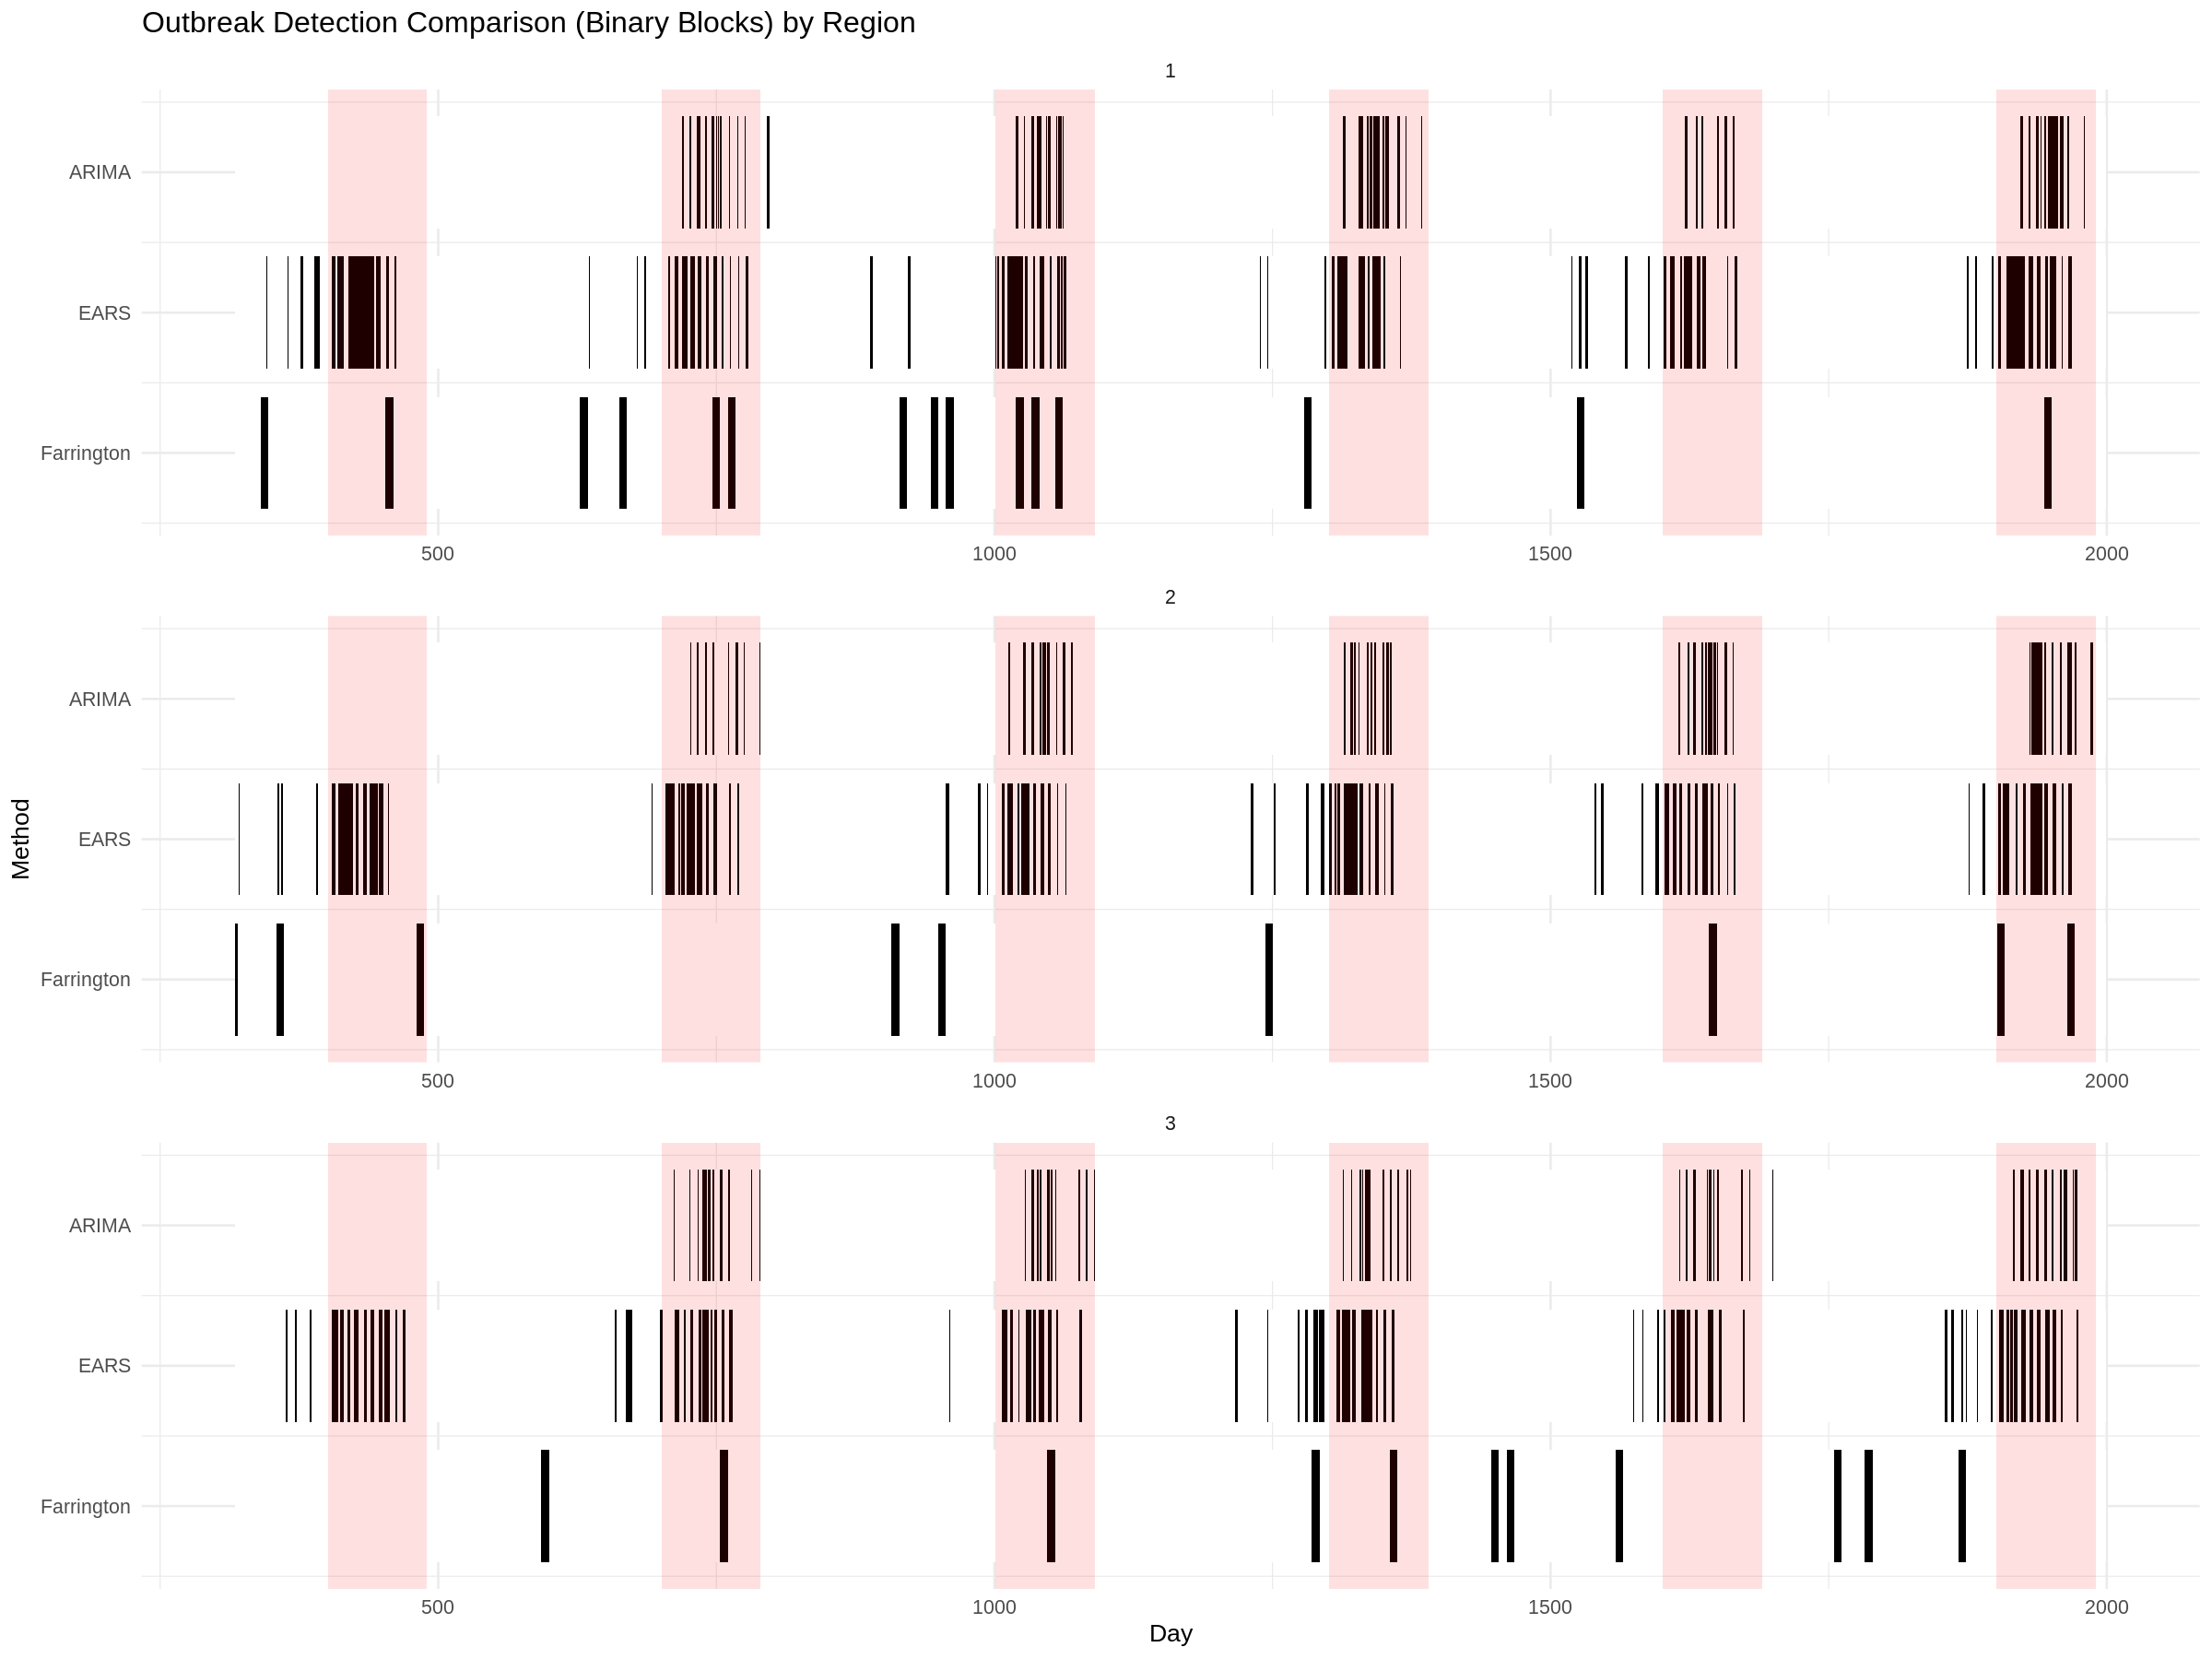

In [35]:
# Take the name of the detectors
method_levels <- names(detectors)

# Gather the signals and organize for the plot
signals_long <- bind_rows(
  lapply(seq_along(all_results), function(i) {
    signals_df <- all_results[[i]]$signals
    signals_df$Region <- region_ids[i]  # Add region ID
    # Pivot just for the detectors you use
    pivot_longer(signals_df,
                 cols = all_of(method_levels),
                 names_to = "Method", values_to = "Detected")
  })
)

signals_long$Method <- factor(signals_long$Method, levels = method_levels)
y_map <- setNames(seq_along(method_levels), method_levels)
signals_long$BlockY <- y_map[as.character(signals_long$Method)]


# Plotting
options(repr.plot.width = 20, repr.plot.height = 15)
ggplot(signals_long, aes(x = Day, y = BlockY, fill = as.factor(Detected))) +
  geom_tile(height = 0.8, width = 1, show.legend = FALSE) +
  geom_rect(
    data = outbreak_periods,
    inherit.aes = FALSE,
    aes(xmin = start, xmax = end, ymin = -Inf, ymax = Inf),
    fill = "red", alpha = 0.12
  ) +
  facet_wrap(~Region, ncol = 1, scales = "free_x") +
  scale_y_continuous(
    breaks = y_map,
    labels = names(y_map),
    expand = c(0.05, 0.05)
  ) +
  scale_fill_manual(values = c("0" = "white", "1" = "black")) +
  labs(
    title = "Outbreak Detection Comparison (Binary Blocks) by Region",
    y = "Method", x = "Day"
  ) +
  theme_minimal(base_size = 16)
